In [9]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import sqlite3

# Subo los archivos en el formato CSV
clientes = pd.read_csv("Clientes.csv")
detalles_pedidos = pd.read_csv("Detalles_Pedidos.csv")
productos = pd.read_csv("Productos.csv")
pedidos = pd.read_csv("Pedidos.csv")

# Después de revisar los problemas de duplicados en la base de Clientes, elimino los correspondientes.
clientes = clientes.drop_duplicates(subset=["ID_Cliente"])

# Valido en todas las bases los datos nulos
print("Clientes - Nulos:\n", clientes.isnull().sum())
print("Pedidos - Nulos:\n", pedidos.isnull().sum())
print("Productos - Nulos:\n", productos.isnull().sum())
print("Detalles_Pedidos - Nulos:\n", detalles_pedidos.isnull().sum())

# Creo la base de datos general con la librería SQLite
conn = sqlite3.connect("ventas.db")
cursor = conn.cursor()

# Añado las tablas según el nombre de las columnas existentes y las que me permiten unificar.
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Clientes (
        ID_Cliente INTEGER PRIMARY KEY,
        Nombre TEXT,
        Email TEXT,
        Ciudad TEXT,
        Fecha_Registro DATE
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Productos (
        ID_Producto TEXT PRIMARY KEY,
        Nombre TEXT,
        Categoria TEXT,
        Precio REAL,
        Stock INTEGER
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Pedidos (
        ID_Pedido INTEGER PRIMARY KEY,
        ID_Cliente INTEGER,
        Fecha DATE,
        Estado TEXT,
        Total REAL,
        FOREIGN KEY (ID_Cliente) REFERENCES Clientes(ID_Cliente)
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Detalles_Pedidos (
        ID_Detalle INTEGER PRIMARY KEY,
        ID_Pedido INTEGER,
        ID_Producto TEXT,
        Cantidad INTEGER,
        Precio_Unitario REAL,
        Subtotal REAL,
        FOREIGN KEY (ID_Pedido) REFERENCES Pedidos(ID_Pedido),
        FOREIGN KEY (ID_Producto) REFERENCES Productos(ID_Producto)
    )
''')

# Verificar IDs existentes en Clientes
existentes = pd.read_sql("SELECT ID_Cliente FROM Clientes", conn)
clientes = clientes[~clientes["ID_Cliente"].isin(existentes["ID_Cliente"])]

# Insertar datos en las tablas
clientes.to_sql("Clientes", conn, if_exists="append", index=False)
productos.to_sql("Productos", conn, if_exists="replace", index=False)
pedidos.to_sql("Pedidos", conn, if_exists="replace", index=False)
detalles_pedidos.to_sql("Detalles_Pedidos", conn, if_exists="replace", index=False)

# Cierro la conexión y compruebo la salida exitosa de los datos en la tabla general.
conn.close()

print("Carga de datos completada exitosamente.")

Clientes - Nulos:
 ID_Cliente        0
Nombre            0
Email             0
Ciudad            0
Fecha_Registro    0
dtype: int64
Pedidos - Nulos:
 ID_Pedido     0
ID_Cliente    0
Fecha         0
Estado        0
Total         0
dtype: int64
Productos - Nulos:
 ID_Producto    0
Nombre         0
Categoría      0
Precio         0
Stock          0
dtype: int64
Detalles_Pedidos - Nulos:
 ID_Detalle         0
ID_Pedido          0
ID_Producto        0
Cantidad           0
Precio_Unitario    0
Subtotal           0
dtype: int64
Carga de datos completada exitosamente.


In [5]:
# Conectar a la base de datos y paso la base a un formato csv.
conn = sqlite3.connect("ventas.db")

# Ejecut la consulta
query = """
SELECT 
    c.ID_Cliente, c.Nombre AS Cliente, c.Email, c.Ciudad, c.Fecha_Registro, 
    p.ID_Pedido, p.Fecha AS Fecha_Pedido, p.Estado, p.Total, 
    d.ID_Producto, pr.Nombre AS Producto, d.Cantidad, d.Precio_Unitario, d.Subtotal
FROM Pedidos p
JOIN Clientes c ON p.ID_Cliente = c.ID_Cliente
JOIN Detalles_Pedidos d ON p.ID_Pedido = d.ID_Pedido
JOIN Productos pr ON d.ID_Producto = pr.ID_Producto;
"""

df = pd.read_sql(query, conn)

# Guardar como CSV
df.to_csv("tabla_unida.csv", index=False)

# Cerrar conexión
conn.close()

print("Archivo 'tabla_unida.csv' generado correctamente.")

Archivo 'tabla_unida.csv' generado correctamente.


In [3]:
pip install --upgrade pandas matplotlib seaborn numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 645.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 7.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 6.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.4
    Uninstalling matplotlib-3.8.4:
      Successfully uninstalled matplotlib-3.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
camelot-py 1.0.0 requires chardet>=5.1.0, but you have chardet 4.0.0 which is incompatible.
camelot-py 1.0.0 requires pdfminer-six>=20240706, but you have

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataframe (si no está cargado)
# df = pd.read_csv('tabla_unida.csv')

# --- Preparación de Datos ---
# Convertir columnas de fecha a datetime para análisis de series de tiempo
df['Fecha_Pedido'] = pd.to_datetime(df['Fecha_Pedido'])
df['Fecha_Registro'] = pd.to_datetime(df['Fecha_Registro'])

# Extraer el mes del pedido para análisis de tendencias
df['Mes_Pedido'] = df['Fecha_Pedido'].dt.to_period('M')

# Establecer un estilo moderno para los gráficos
plt.style.use('seaborn-v0_8-whitegrid')

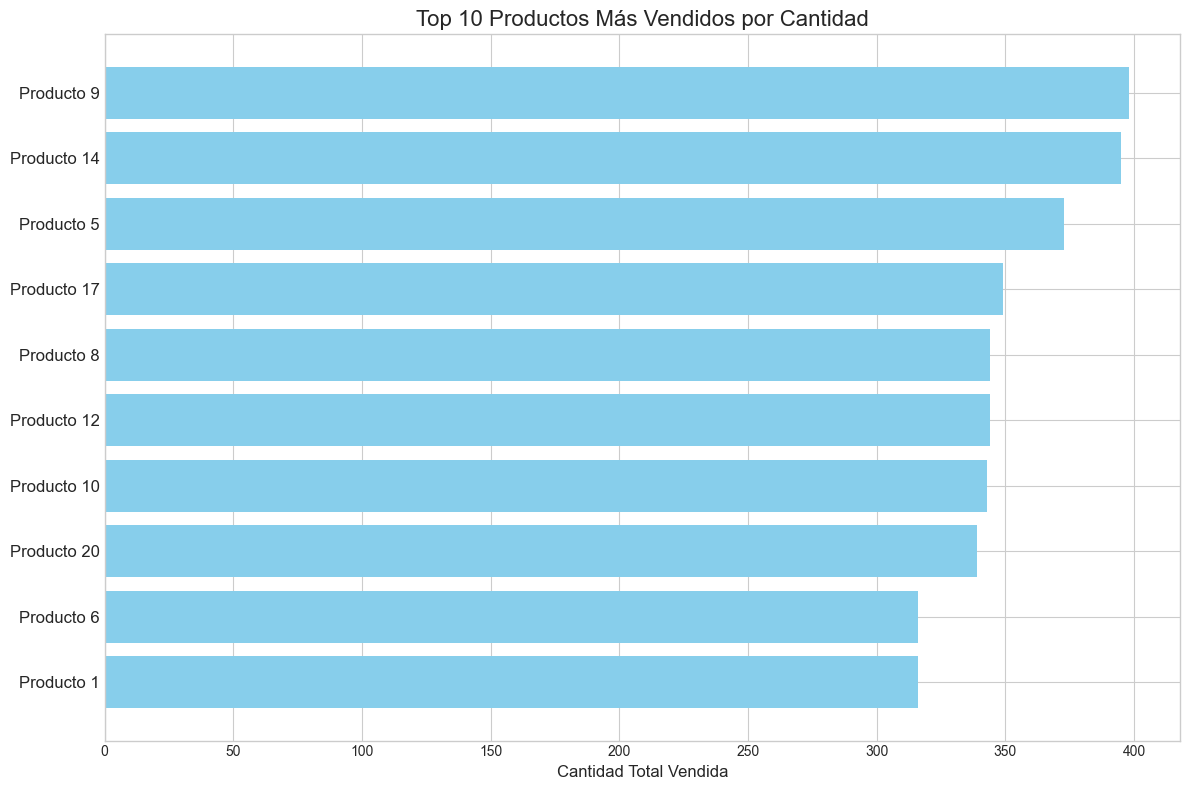

In [9]:
# 1. Agrupar datos
top_productos = df.groupby('Producto')['Cantidad'].sum().nlargest(10).sort_values(ascending=True)

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_productos.index, top_productos.values, color='skyblue')

ax.set_title('Top 10 Productos Más Vendidos por Cantidad', fontsize=16)
ax.set_xlabel('Cantidad Total Vendida', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

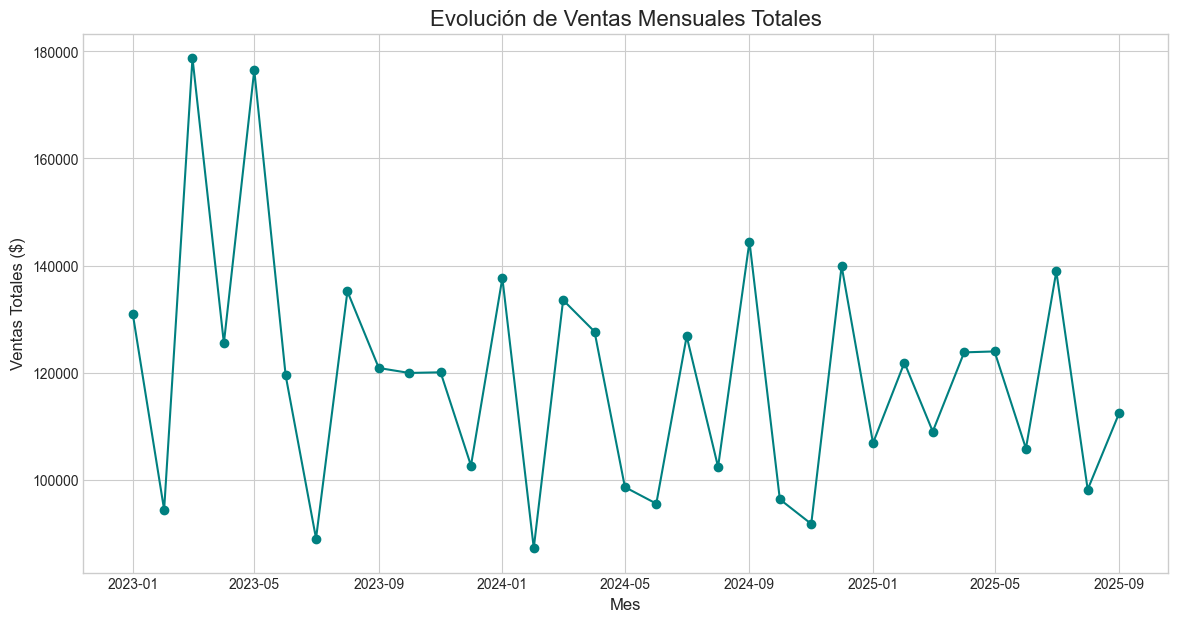

In [11]:
# 1. Agrupar datos
ventas_mensuales = df.groupby(df['Fecha_Pedido'].dt.to_period('M'))['Total'].sum()
ventas_mensuales.index = ventas_mensuales.index.to_timestamp()

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(ventas_mensuales.index, ventas_mensuales.values, marker='o', linestyle='-', color='teal')

ax.set_title('Evolución de Ventas Mensuales Totales', fontsize=16)
ax.set_ylabel('Ventas Totales ($)', fontsize=12)
ax.set_xlabel('Mes', fontsize=12)
plt.show()

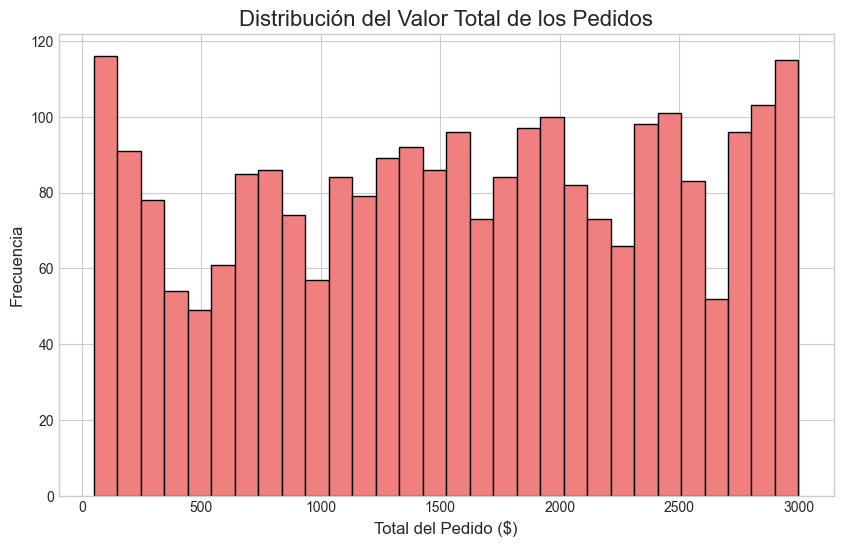

In [13]:
# Crear visualización
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df['Total'], bins=30, color='lightcoral', edgecolor='black')

ax.set_title('Distribución del Valor Total de los Pedidos', fontsize=16)
ax.set_xlabel('Total del Pedido ($)', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
plt.show()

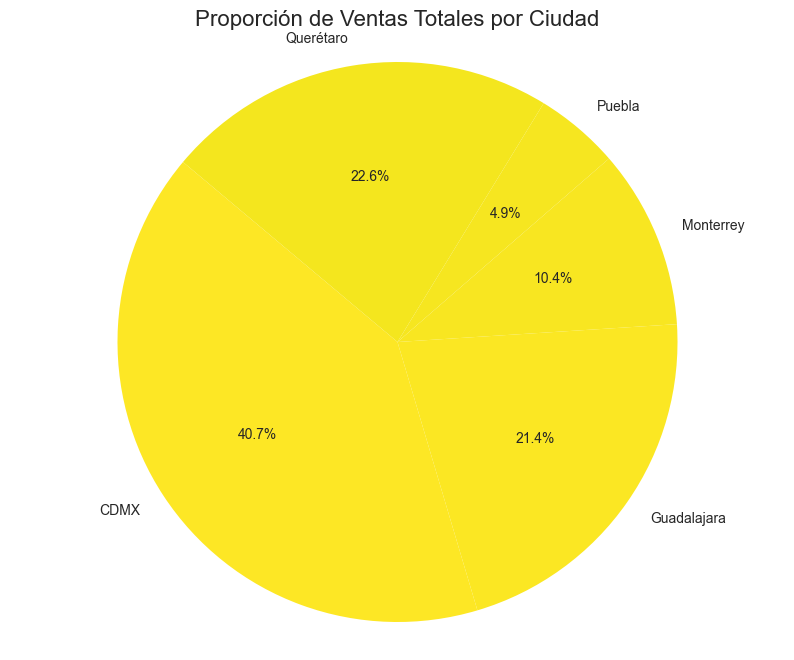

In [15]:
# 1. Agrupar datos
ventas_ciudad = df.groupby('Ciudad')['Total'].sum()

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(ventas_ciudad, labels=ventas_ciudad.index, autopct='%1.1f%%', startangle=140,
       colors=plt.cm.viridis_r(range(len(ventas_ciudad))))
ax.set_title('Proporción de Ventas Totales por Ciudad', fontsize=16)
ax.axis('equal') # Asegura que el pastel sea un círculo
plt.show()

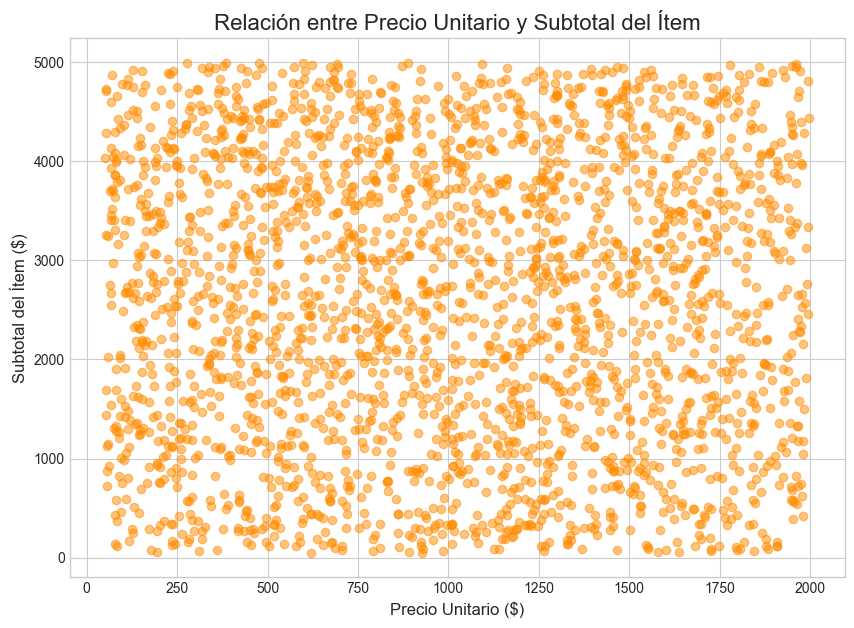

In [17]:
# Crear visualización
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(df['Precio_Unitario'], df['Subtotal'], alpha=0.5, color='darkorange')

ax.set_title('Relación entre Precio Unitario y Subtotal del Ítem', fontsize=16)
ax.set_xlabel('Precio Unitario ($)', fontsize=12)
ax.set_ylabel('Subtotal del Ítem ($)', fontsize=12)
plt.show()

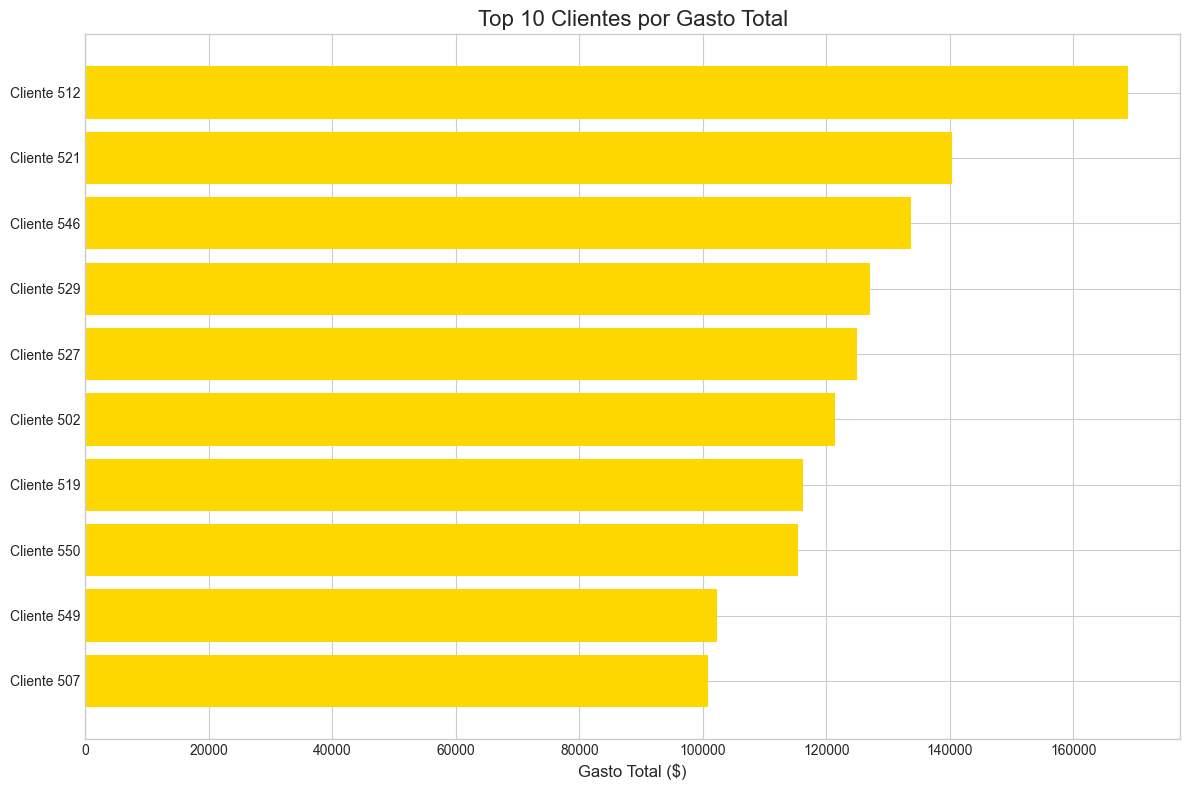

In [19]:
# 1. Agrupar datos
top_clientes = df.groupby('Cliente')['Total'].sum().nlargest(10).sort_values(ascending=True)

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_clientes.index, top_clientes.values, color='gold')

ax.set_title('Top 10 Clientes por Gasto Total', fontsize=16)
ax.set_xlabel('Gasto Total ($)', fontsize=12)
plt.tight_layout()
plt.show()

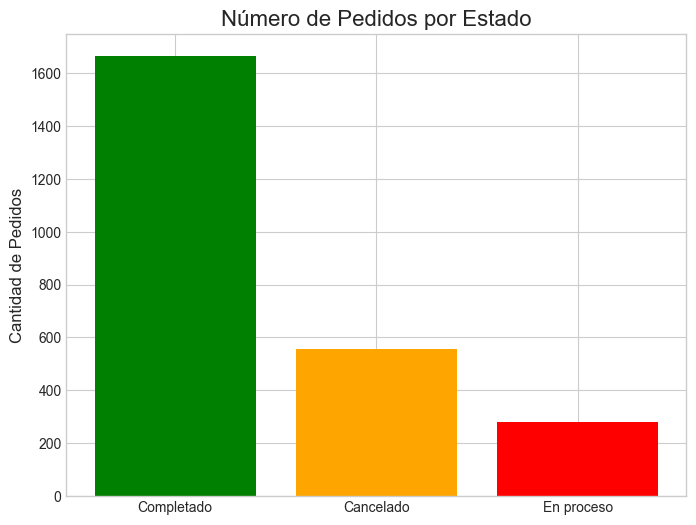

In [21]:
# 1. Contar valores
estado_counts = df['Estado'].value_counts()

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(estado_counts.index, estado_counts.values, color=['green', 'orange', 'red'])

ax.set_title('Número de Pedidos por Estado', fontsize=16)
ax.set_ylabel('Cantidad de Pedidos', fontsize=12)
plt.show()

/var/folders/cy/gjg9tdvn4636nfn4bl10381w0000gn/T/ipykernel_690/370837910.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_por_ciudad, labels=df['Ciudad'].unique(), patch_artist=True)


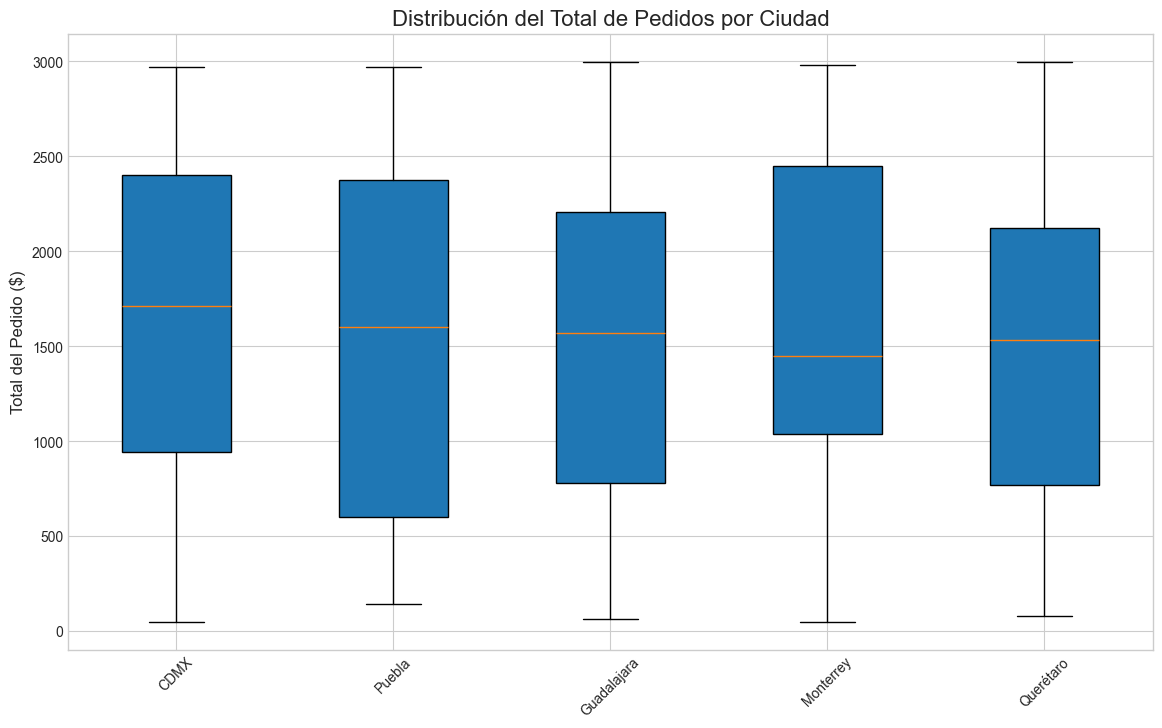

In [23]:
# 1. Preparar datos
data_por_ciudad = [df[df['Ciudad'] == ciudad]['Total'] for ciudad in df['Ciudad'].unique()]

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(14, 8))
ax.boxplot(data_por_ciudad, labels=df['Ciudad'].unique(), patch_artist=True)

ax.set_title('Distribución del Total de Pedidos por Ciudad', fontsize=16)
ax.set_ylabel('Total del Pedido ($)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

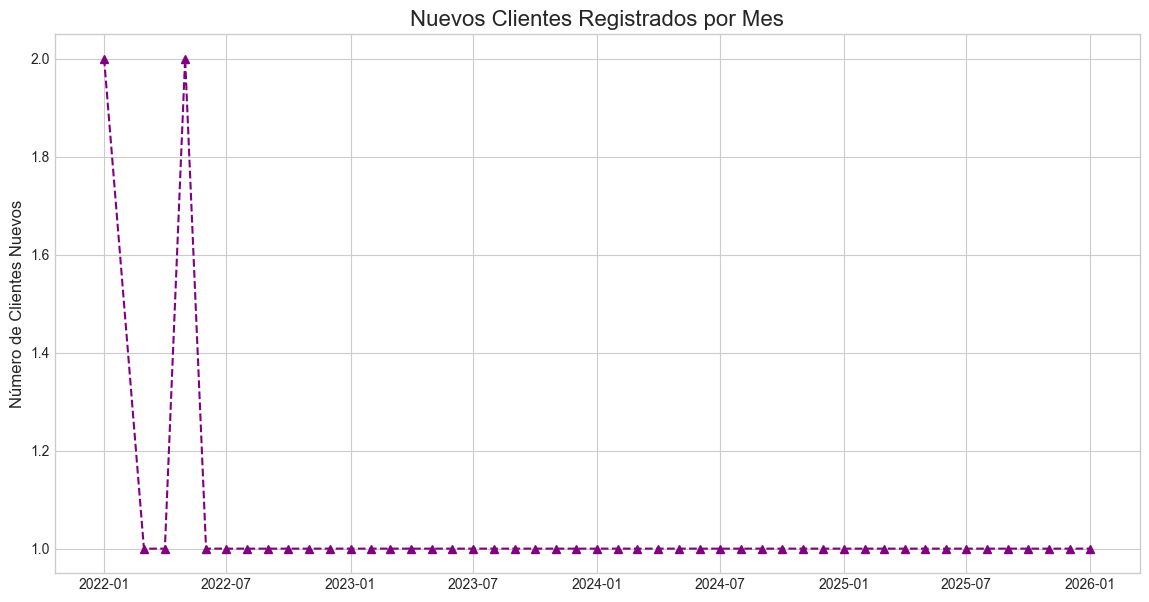

In [25]:
# 1. Agrupar datos
registros_mensuales = df.groupby(df['Fecha_Registro'].dt.to_period('M'))['ID_Cliente'].nunique()
registros_mensuales.index = registros_mensuales.index.to_timestamp()

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(registros_mensuales.index, registros_mensuales.values, marker='^', linestyle='--', color='purple')

ax.set_title('Nuevos Clientes Registrados por Mes', fontsize=16)
ax.set_ylabel('Número de Clientes Nuevos', fontsize=12)
plt.show()

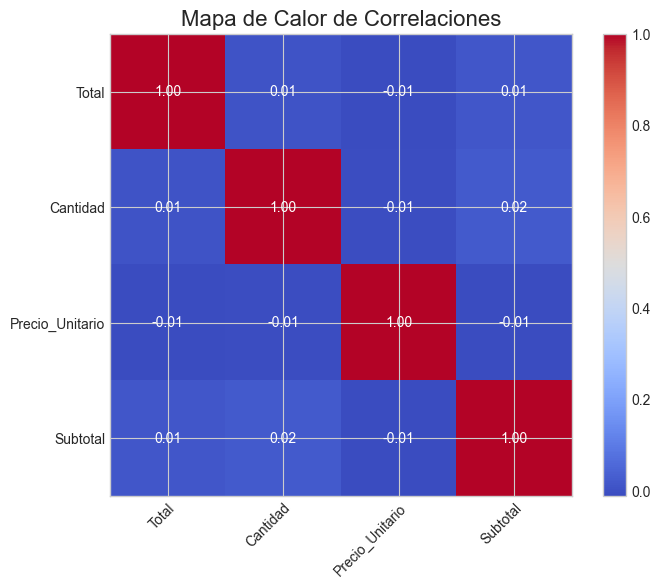

In [27]:
# 1. Calcular correlación
numeric_df = df[['Total', 'Cantidad', 'Precio_Unitario', 'Subtotal']]
corr_matrix = numeric_df.corr()

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Añadir anotaciones
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="w")

ax.set_title('Mapa de Calor de Correlaciones', fontsize=16)
plt.show()

/var/folders/cy/gjg9tdvn4636nfn4bl10381w0000gn/T/ipykernel_690/3963890347.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Ciudad', y='Total', estimator=sum, errorbar=None, palette='viridis')


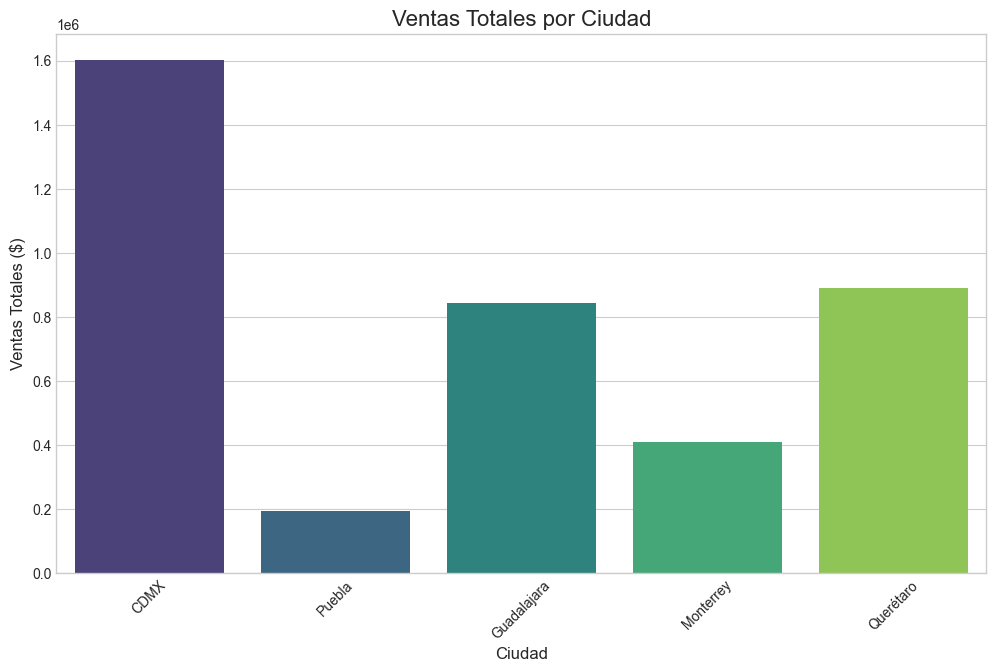

In [29]:
plt.figure(figsize=(12, 7))
sns.barplot(data=df, x='Ciudad', y='Total', estimator=sum, errorbar=None, palette='viridis')
plt.title('Ventas Totales por Ciudad', fontsize=16)
plt.ylabel('Ventas Totales ($)', fontsize=12)
plt.xlabel('Ciudad', fontsize=12)
plt.xticks(rotation=45)
plt.show()

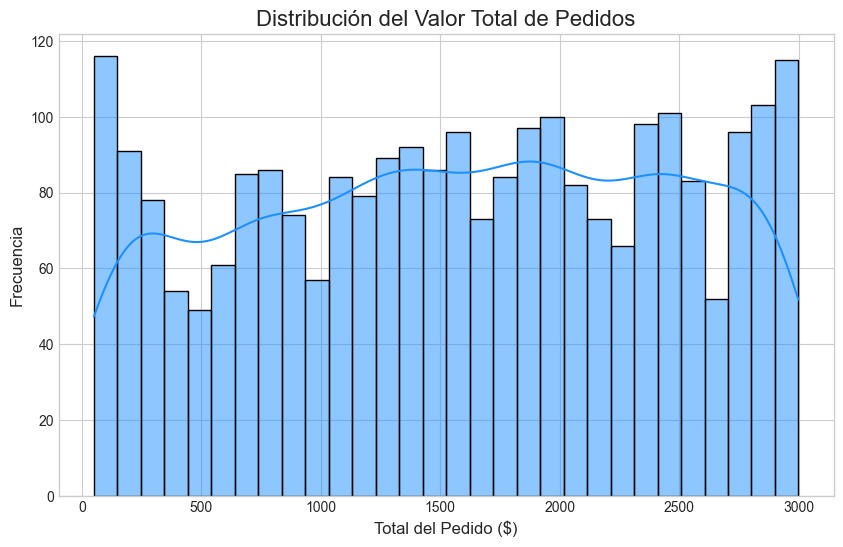

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Total'], kde=True, bins=30, color='dodgerblue')
plt.title('Distribución del Valor Total de Pedidos', fontsize=16)
plt.xlabel('Total del Pedido ($)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

/var/folders/cy/gjg9tdvn4636nfn4bl10381w0000gn/T/ipykernel_690/1416798526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_ciudades['Mes_Pedido'] = df_top_ciudades['Fecha_Pedido'].dt.to_period('M').dt.to_timestamp()


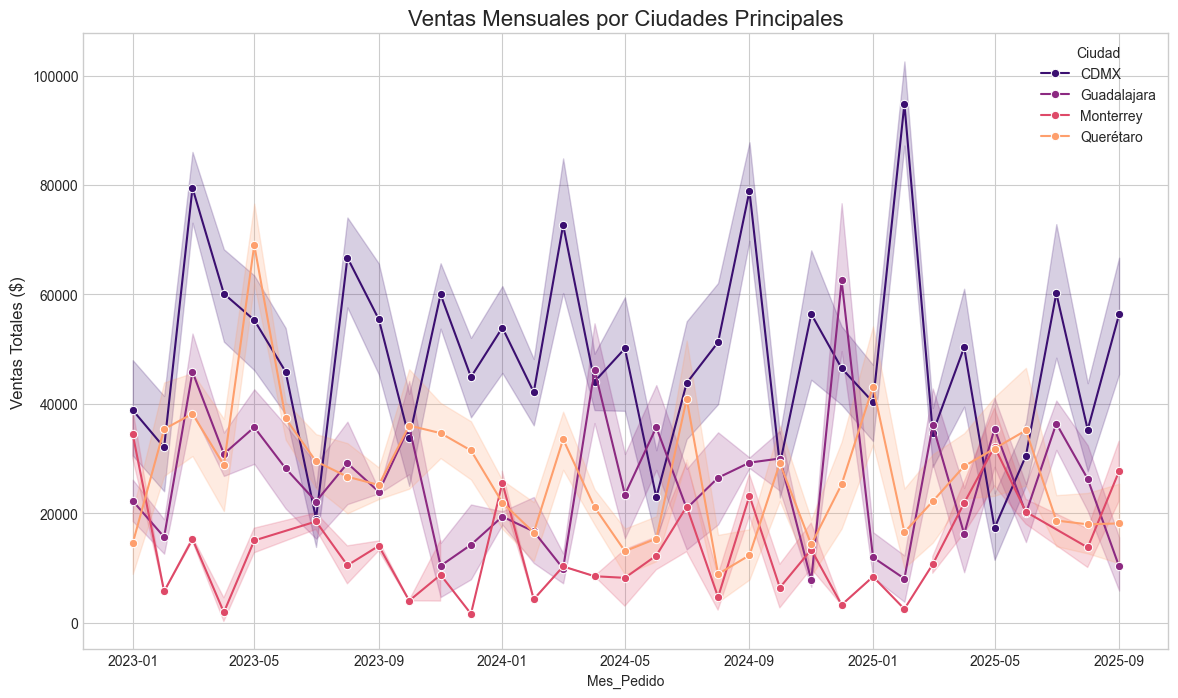

In [33]:
# 1. Filtrar por las 4 ciudades con más ventas
top_4_ciudades = df.groupby('Ciudad')['Total'].sum().nlargest(4).index
df_top_ciudades = df[df['Ciudad'].isin(top_4_ciudades)]
df_top_ciudades['Mes_Pedido'] = df_top_ciudades['Fecha_Pedido'].dt.to_period('M').dt.to_timestamp()


# 2. Crear visualización
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_top_ciudades, x='Mes_Pedido', y='Total', hue='Ciudad',
             marker='o', estimator='sum', palette='magma')
plt.title('Ventas Mensuales por Ciudades Principales', fontsize=16)
plt.ylabel('Ventas Totales ($)', fontsize=12)
plt.show()

/var/folders/cy/gjg9tdvn4636nfn4bl10381w0000gn/T/ipykernel_690/4103162040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Ciudad', y='Total', palette='coolwarm')


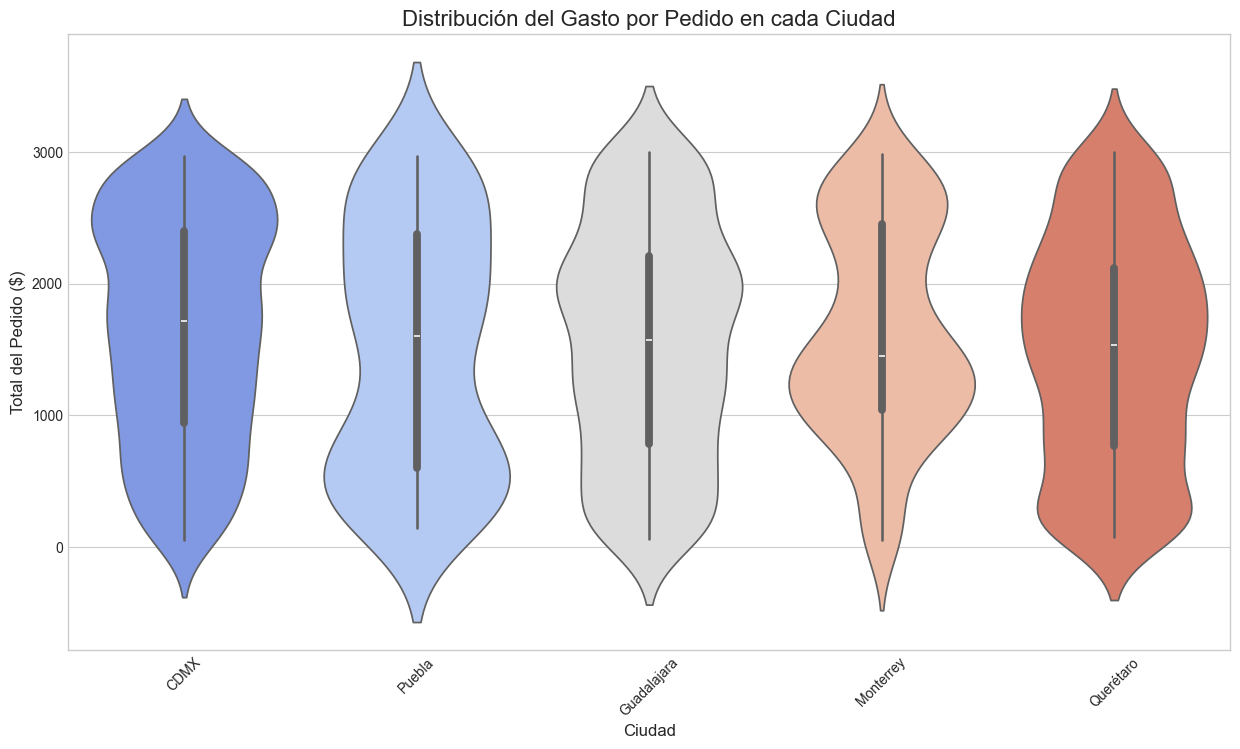

In [35]:
plt.figure(figsize=(15, 8))
sns.violinplot(data=df, x='Ciudad', y='Total', palette='coolwarm')
plt.title('Distribución del Gasto por Pedido en cada Ciudad', fontsize=16)
plt.xlabel('Ciudad', fontsize=12)
plt.ylabel('Total del Pedido ($)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

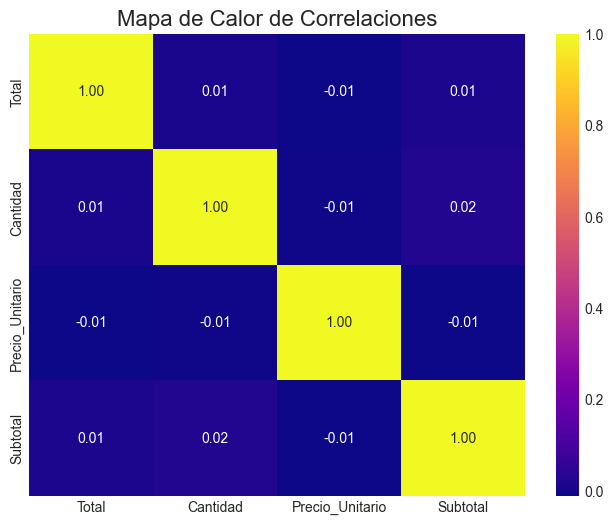

In [37]:
numeric_df = df[['Total', 'Cantidad', 'Precio_Unitario', 'Subtotal']]
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones', fontsize=16)
plt.show()

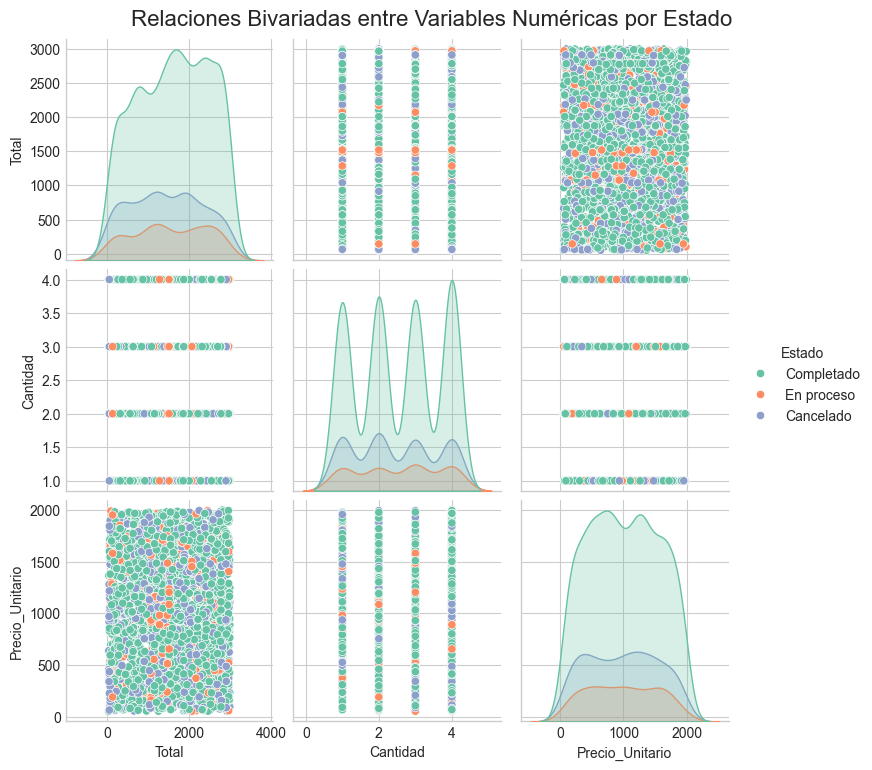

In [39]:
# Usar solo un subconjunto de datos para que el gráfico se genere más rápido
sns.pairplot(df[['Total', 'Cantidad', 'Precio_Unitario', 'Estado']], hue='Estado', palette='Set2')
plt.suptitle('Relaciones Bivariadas entre Variables Numéricas por Estado', y=1.02, fontsize=16)
plt.show()

/var/folders/cy/gjg9tdvn4636nfn4bl10381w0000gn/T/ipykernel_690/167170177.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Dia_Semana_Pedido', order=dias_ordenados, palette='spring')


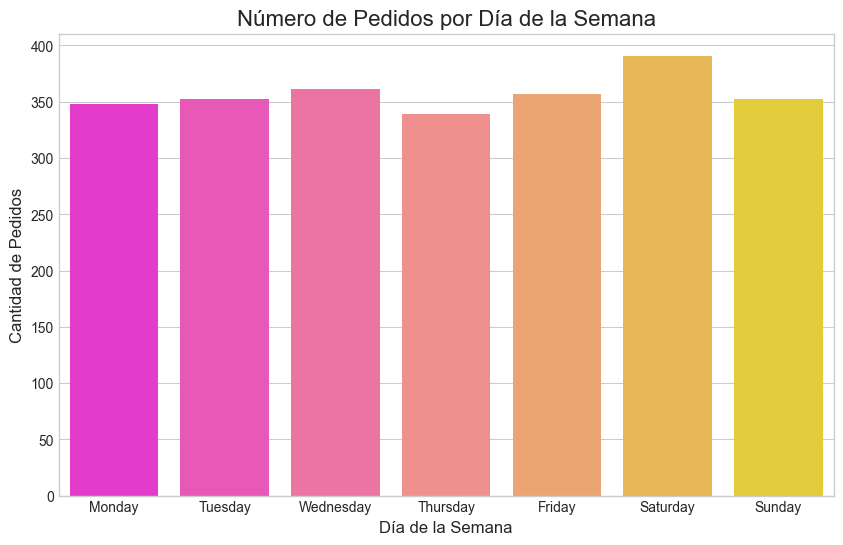

In [41]:
df['Dia_Semana_Pedido'] = df['Fecha_Pedido'].dt.day_name()
dias_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Dia_Semana_Pedido', order=dias_ordenados, palette='spring')
plt.title('Número de Pedidos por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Cantidad de Pedidos', fontsize=12)
plt.show()

/var/folders/cy/gjg9tdvn4636nfn4bl10381w0000gn/T/ipykernel_690/523977670.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=top_5_per_city, x='Cantidad', y='Producto', col='Ciudad',


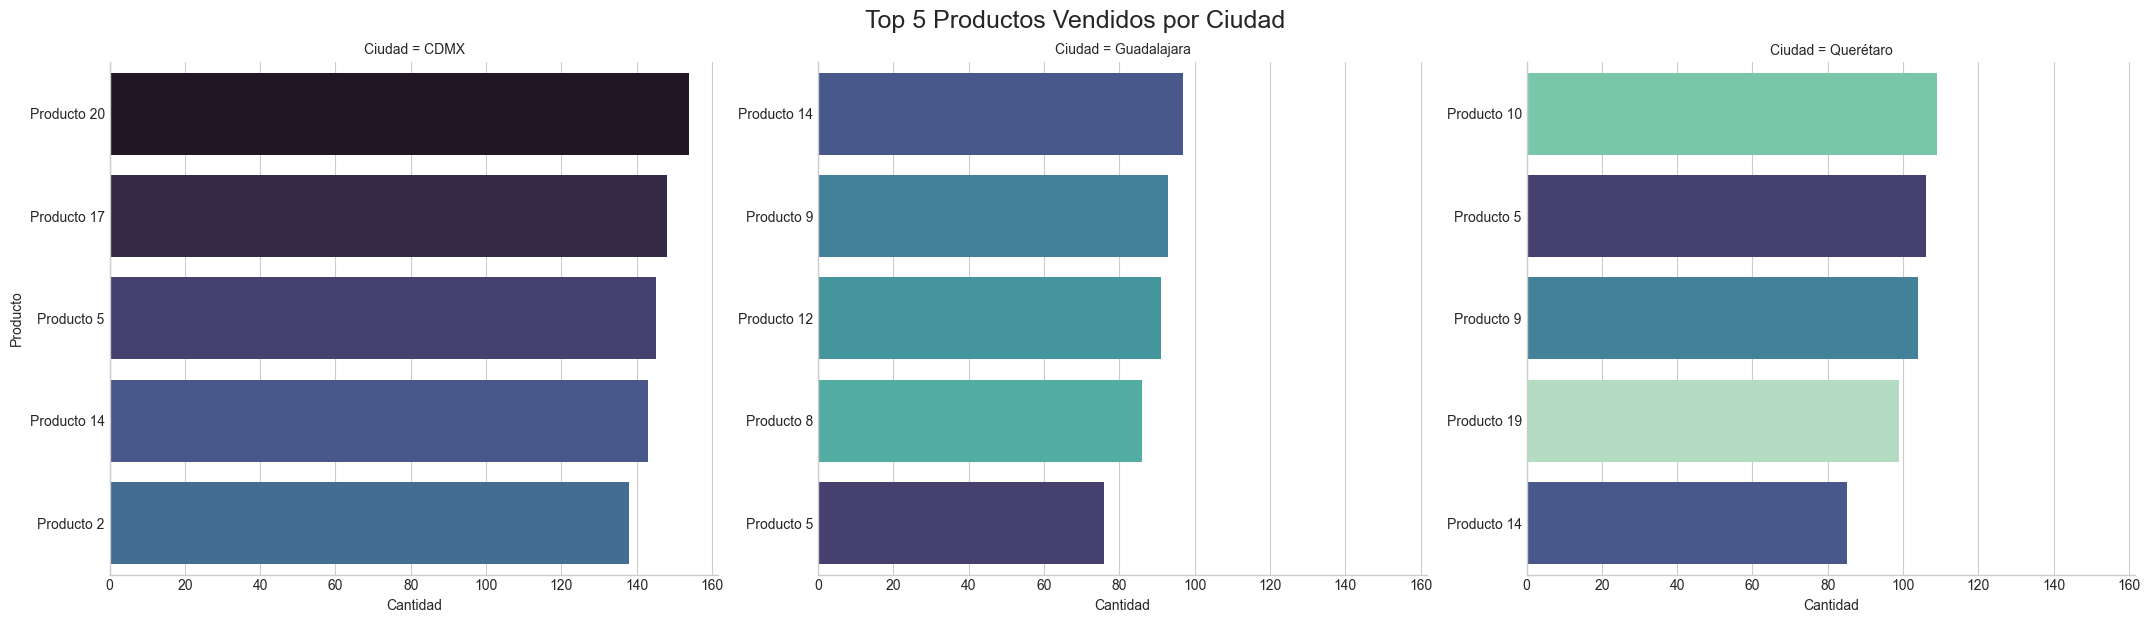

In [43]:
# Lógica para encontrar el top 5 de productos para cada una de las top 3 ciudades
top_3_ciudades = df['Ciudad'].value_counts().nlargest(3).index
df_top_cities = df[df['Ciudad'].isin(top_3_ciudades)]

# Calcula los 5 productos más vendidos para CADA una de esas ciudades
top_products_per_city = df_top_cities.groupby(['Ciudad', 'Producto'])['Cantidad'].sum().reset_index()
top_products_per_city = top_products_per_city.sort_values(['Ciudad', 'Cantidad'], ascending=[True, False])
top_5_per_city = top_products_per_city.groupby('Ciudad').head(5)

# Crear la visualización
sns.catplot(data=top_5_per_city, x='Cantidad', y='Producto', col='Ciudad',
            kind='bar', col_wrap=3, sharey=False, palette='mako', height=6, aspect=1.2)
plt.suptitle('Top 5 Productos Vendidos por Ciudad', y=1.03, fontsize=18)
plt.show()

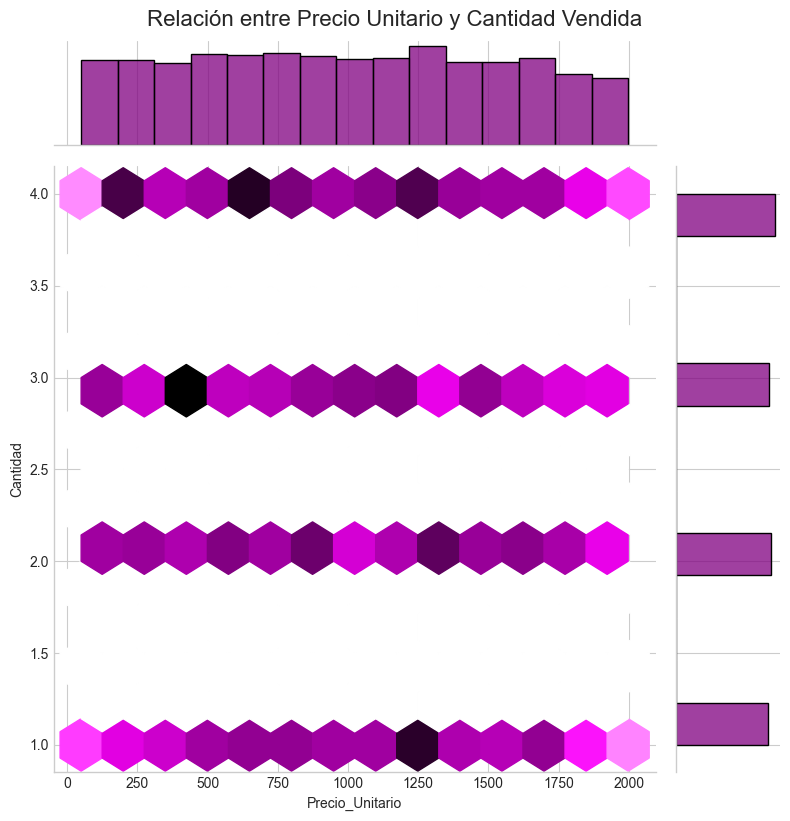

In [45]:
sns.jointplot(data=df, x='Precio_Unitario', y='Cantidad', kind='hex', color='purple', height=8)
plt.suptitle('Relación entre Precio Unitario y Cantidad Vendida', y=1.02, fontsize=16)
plt.show()

/var/folders/cy/gjg9tdvn4636nfn4bl10381w0000gn/T/ipykernel_690/3939514891.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df, x='Estado', y='Total', palette='Paired')


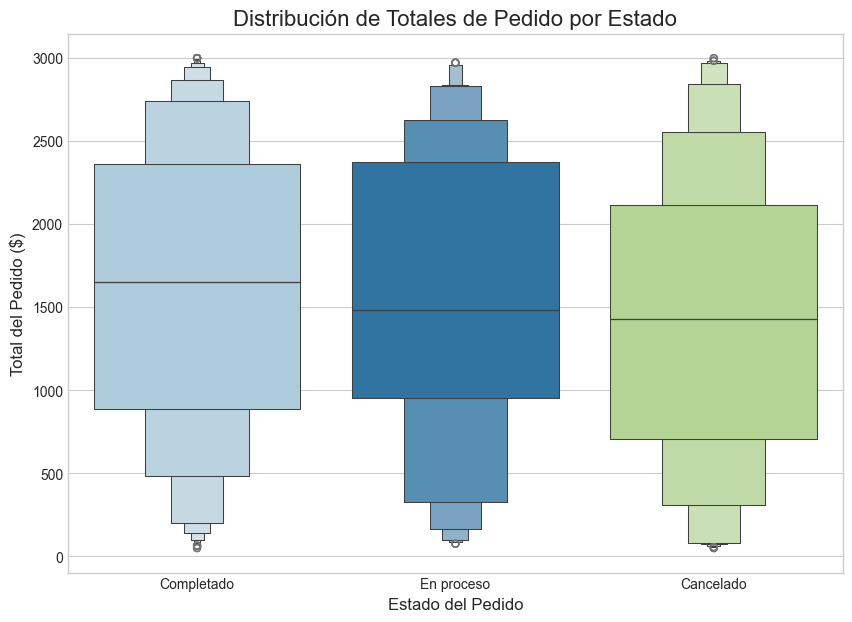

In [47]:
plt.figure(figsize=(10, 7))
sns.boxenplot(data=df, x='Estado', y='Total', palette='Paired')
plt.title('Distribución de Totales de Pedido por Estado', fontsize=16)
plt.xlabel('Estado del Pedido', fontsize=12)
plt.ylabel('Total del Pedido ($)', fontsize=12)
plt.show()

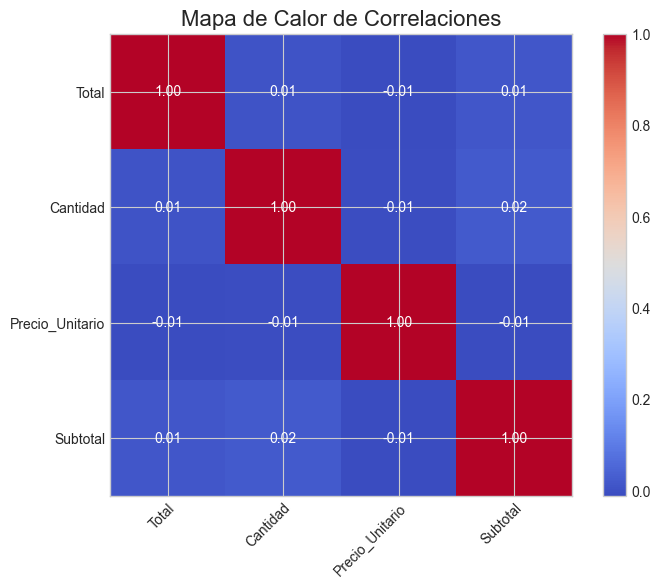

In [49]:
# 1. Calcular correlación
numeric_df = df[['Total', 'Cantidad', 'Precio_Unitario', 'Subtotal']]
corr_matrix = numeric_df.corr()

# 2. Crear visualización
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Añadir anotaciones
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="w")

ax.set_title('Mapa de Calor de Correlaciones', fontsize=16)
plt.show()